## Model I/O

The core element of any language model application is...the model. LangChain gives you the building blocks to interface with any language model.

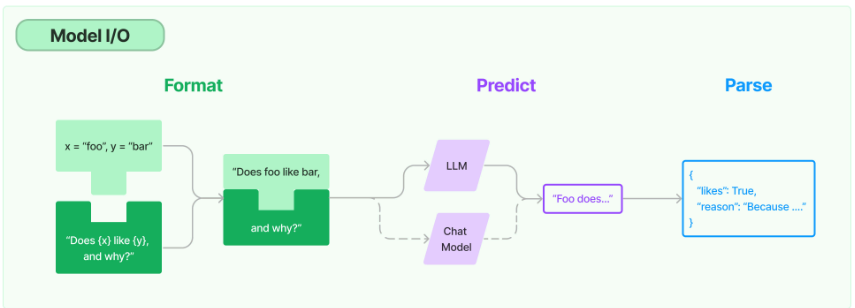

1. Two different types of models - LLMs and Chat Models.
2. How to use Prompt Templates to format the inputs to these models.
3. How to use Output Parsers to work with the outputs.

Language models in LangChain come in two flavors:

1. Chat models:
   * Chat models are often backed by LLMs but tuned specifically for having conversations.
   * Instead of a single string, they take a list of chat messages as input and they return an AI message as output.
   * GPT-4 and Anthropic's Claude-2 are both implemented as chat models.

2. LLMs:
   * LLMs in LangChain refer to pure text completion models.
   * The APIs they wrap take a string prompt as input and output a string completion.
   * Example: OpenAI's GPT-3 is implemented as an LLM.
  
These two API types have different input and output schemas. Different models have different prompting strategies that work best for them. For example, Anthropic's models work best with XML while OpenAI's work best with JSON.

In [1]:
import os
os.environ["OPENAI_API_KEY"] = "Your_api_key"

In [2]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAI

llm = OpenAI()
chat_model = ChatOpenAI(model="gpt-3.5-turbo-0125")

Both llm and chat_model are objects that represent configuration for a particular model.

You can initialize them with parameters like temperature and others, and pass them around.

The main difference between them is their input and output schemas.

The LLM objects take string as input and output string.

The ChatModel objects take a list of messages as input and output a message.

In [3]:
from langchain_core.messages import HumanMessage

text = "What would be a good company name for a company that makes colorful socks?"
messages = [HumanMessage(content=text)]

chat_model.invoke(messages) # returns a message

AIMessage(content='Rainbow Sock Co.', response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 22, 'total_tokens': 28}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': 'fp_a450710239', 'finish_reason': 'stop', 'logprobs': None}, id='run-26440c53-4719-442b-afae-549077857cf4-0')

In [4]:
llm.invoke(text) # returns a string

'\n\n"Rainbow Threads" or "Chroma Socks"'

In [5]:
print(messages)

[HumanMessage(content='What would be a good company name for a company that makes colorful socks?')]


#### Prompt Templates

Most LLM applications do not pass user input directly into an LLM. 

Usually they will add the user input to a larger piece of text, called a prompt template, that provides additional context on the specific task at hand.

PromptTemplates bundle up all the logic for going from user input into a fully formatted prompt.

https://python.langchain.com/docs/modules/model_io/prompts/

In [6]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template("What is a good name for a company that makes {product}?")
prompt.format(product="colorful socks")

'What is a good name for a company that makes colorful socks?'

PromptTemplates can also be used to produce a list of messages.

Here, what happens most often is a ChatPromptTemplate is a list of ChatMessageTemplates. Each ChatMessageTemplate contains instructions for how to format that ChatMessage - its role, and then also its content.

In [7]:
from langchain_core.prompts.chat import ChatPromptTemplate

template = "You are a helpful assistant that translates {input_language} to {output_language}."
human_template = "{text}"

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("human", human_template),
])

chat_prompt.format_messages(input_language="English", output_language="French", text="I love programming.")

[SystemMessage(content='You are a helpful assistant that translates English to French.'),
 HumanMessage(content='I love programming.')]

#### Output parsers

OutputParsers convert the raw output of a language model into a format that can be used downstream.

There are a few main types of OutputParsers, including:

1. Convert text from LLM into structured information (e.g. JSON)
2. Convert a ChatMessage into just a string
3. Convert the extra information returned from a call besides the message (like OpenAI function invocation) into a string.

In [9]:
from langchain.output_parsers import CommaSeparatedListOutputParser

output_parser = CommaSeparatedListOutputParser()
output_parser.parse("hi, bye") # parses a list of comma separated values.

['hi', 'bye']

#### Composing with LCEL

This chain will take input variables, pass those to a prompt template to create a prompt, pass the prompt to a language model, and then pass the output through an (optional) output parser.

In [12]:
template = "Generate a list of 5 {text}.\n\n{format_instructions}"

chat_prompt = ChatPromptTemplate.from_template(template)
print(f"1. {chat_prompt} \n")
chat_prompt = chat_prompt.partial(format_instructions=output_parser.get_format_instructions())
print(f"2. {chat_prompt} \n")

1. input_variables=['format_instructions', 'text'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['format_instructions', 'text'], template='Generate a list of 5 {text}.\n\n{format_instructions}'))] 

2. input_variables=['text'] partial_variables={'format_instructions': 'Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['format_instructions', 'text'], template='Generate a list of 5 {text}.\n\n{format_instructions}'))] 



In [13]:
chain = chat_prompt | chat_model | output_parser
chain.invoke({"text": "colors"})

['red', 'blue', 'green', 'yellow', 'purple']